### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

fatal: destination path 'cv_project' already exists and is not an empty directory.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=14757 sha256=06bbec06f1b3fde197d2de34bdde31c1b5c5027ab39fbb19bf2ebcb0ac57d2d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mmver6l4/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-_g93q9zv
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-_g93q9zv
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=7150e5e07e0fbbf9ba3259c52d85d7948ed791819bc67927bdabecad0871ff00
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbwjl0ap/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [6]:
pip install stellargraph

In [7]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classification_models.keras import Classifiers
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow

# Aerial-Cars-Dataset
# ResNet18
# Pipeline: Norm

### Load dataset

In [8]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'

In [9]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet18

In [10]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 50

In [11]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(
    input_shape=X[0].shape,
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers:
    layer.trainable = False

x = K.layers.GlobalAveragePooling2D()(base_model.output)
output = K.layers.Dense(2, activation='softmax')(x)
model = K.models.Model(inputs=[base_model.input], outputs=[output])


model.compile(
    optimizer=K.optimizers.Adam(0.01),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

Epoch 1/50
43/43 [==============================] - 10s 45ms/step - loss: 0.7157 - accuracy: 0.5050 - val_loss: 0.6760 - val_accuracy: 0.5191
Epoch 2/50
43/43 [==============================] - 1s 23ms/step - loss: 0.6776 - accuracy: 0.5515 - val_loss: 0.6525 - val_accuracy: 0.8051
Epoch 3/50
43/43 [==============================] - 1s 24ms/step - loss: 0.6543 - accuracy: 0.6404 - val_loss: 0.6566 - val_accuracy: 0.5212
Epoch 4/50
43/43 [==============================] - 1s 24ms/step - loss: 0.6474 - accuracy: 0.6124 - val_loss: 0.6122 - val_accuracy: 0.8030
Epoch 5/50
43/43 [==============================] - 1s 24ms/step - loss: 0.6114 - accuracy: 0.7696 - val_loss: 0.6204 - val_accuracy: 0.5699
Epoch 6/50
43/43 [==============================] - 1s 24ms/step - loss: 0.6144 - accuracy: 0.6228 - val_loss: 0.5904 - val_accuracy: 0.7013
Epoch 7/50
43/43 [==============================] - 1s 24ms/step - loss: 0.5925 - accuracy: 0.7334 - val_loss: 0.5702 - val_accuracy: 0.8093
Epoch 8/50
4

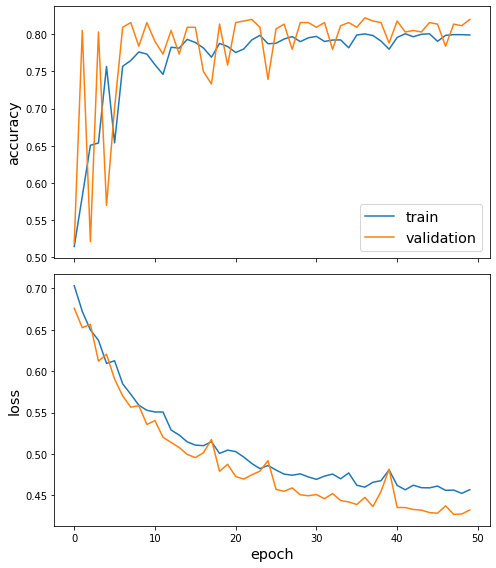

In [12]:
plot_history(history)

### Validation

In [13]:
from tqdm import tqdm
from copy import deepcopy

def validate_model(
    dataset_loader,
    input_folder_filepath,
    images_files_types,
    annotations_files_types,
    detector,
    workers = 0
):

    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers)
        )

    return processed_images

In [ ]:
data = None

In [17]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.3
)

In [18]:
processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val_dev',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

  0%|          | 0/1 [00:00<?, ?it/s]

(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
249
Overlap is 0.2562109434537418
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.19524462734339276
Overlap is 0.3811918914799573
Overlap is 0.009297363206828228
Overlap is 0.012345679012345678
Overlap is 0.006249047401310776
Overlap is 0.009297363206828228
Overlap is 0.19524462734339276
Overlap is 0.009297363206828228
Overlap is 0.3811918914799573
Overlap is 0.25925925925925924
Overlap is 0.5671391556165218
Overlap is 0.3811918914799573
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.009297363206828228
Overlap is 0.56

100%|██████████| 1/1 [00:03<00:00,  3.35s/it]

 0.2562109434537418
Overlap is 0.012345679012345678
Overlap is 0.13122999542752628
Overlap is 0.009297363206828228
Overlap is 0.19524462734339276
Overlap is 0.00015241579027587258
Overlap is 0.13122999542752628
Overlap is 0.006249047401310776
Overlap is 0.19524462734339276
Overlap is 0.003200731595793324
Overlap is 0.06721536351165981
Overlap is 0.5061728395061729
Overlap is 0.2562109434537418
Overlap is 0.3811918914799573
Overlap is 0.13122999542752628
Overlap is 0.3811918914799573
Overlap is 0.13122999542752628
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.06721536351165981
Overlap is 0.5061728395061729
Overlap is 0.25925925925925924
Overlap is 0.2562109434537418
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.5671391556165218
Overlap is 0.5061728395061729
Overlap is 0.2562109434537418
Overlap is 0.5671391556165218
Overlap is 0.13122999542752628
Overlap is 0.19524462734339276
Overlap is 0.5671391556165218
Overlap is 0.7530864197530

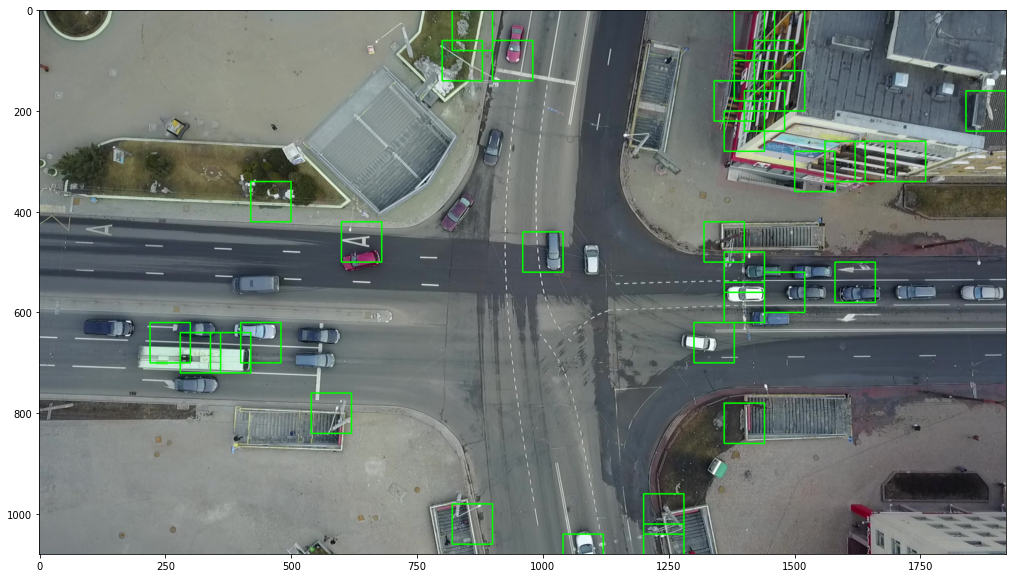

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])